# 09. Advanced Trajectory Models

## Objective
Evaluate machine learning models using the **advanced feature set** (sport-specific and gender-specific metrics) to improve classification performance.

## Inputs
- `trajectory_ml_ready_advanced.csv`: The enhanced dataset.

## Steps
1. **Load Data**: Read the advanced dataset.
2. **Preprocessing**: Handle categorical variables and scaling.
3. **Model Training**: Train Random Forest and XGBoost.
4. **Evaluation**: Compare performance with the baseline models.
5. **Feature Importance**: Analyze the impact of new features (Football, Gender, etc.).

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Set plot style
sns.set(style="whitegrid")

## 1. Load Data

In [5]:
# Load the dataset
df = pd.read_csv('../trajectory_ml_ready_advanced.csv')

# Display basic info
print(f"Dataset Shape: {df.shape}")
print("Columns:", df.columns.tolist())

Dataset Shape: (12054, 27)
Columns: ['UNITID', 'Institution_Name', 'Year', 'State', 'Division', 'Grand Total Revenue', 'Grand Total Expenses', 'Total_Athletes', 'Revenue_Growth_1yr', 'Expense_Growth_1yr', 'Revenue_CAGR_2yr', 'Expense_CAGR_2yr', 'Revenue_Mean_2yr', 'Expense_Mean_2yr', 'Efficiency_Mean_2yr', 'Revenue_Volatility_2yr', 'Expense_Volatility_2yr', 'Mens_Expense_Share', 'Womens_Expense_Share', 'Football_Revenue_Share', 'Football_Expense_Share', 'Has_Football', 'Male_Athlete_Share', 'Revenue_Per_Athlete', 'Expense_Per_Athlete', 'Target_Trajectory', 'Target_Label']


## 2. Preprocessing

In [6]:
# Define features and target
drop_cols = ['UNITID', 'Institution_Name', 'Year', 'Target_Trajectory', 'Target_Label', 'State']

X = df.drop(columns=drop_cols)
y = df['Target_Label']

# Encode categorical variables (e.g., Division)
X = pd.get_dummies(X, columns=['Division'], drop_first=True)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print(f"Training Set: {X_train.shape}")
print(f"Testing Set: {X_test.shape}")

Training Set: (9643, 22)
Testing Set: (2411, 22)


## 3. Model Training & Evaluation

In [7]:
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test) if hasattr(model, 'predict_proba') else None
    
    print(f"--- {model_name} ---")
    print(classification_report(y_test, y_pred))
    
    if y_prob is not None:
        try:
            auc = roc_auc_score(y_test, y_prob, multi_class='ovr')
            print(f"ROC-AUC Score: {auc:.4f}")
        except ValueError:
            print("Could not calculate ROC-AUC")
    print("\n")

# 1. Random Forest
pipeline_rf = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(n_estimators=200, max_depth=15, random_state=42))
])

pipeline_rf.fit(X_train, y_train)
evaluate_model(pipeline_rf, X_test, y_test, "Random Forest (Advanced)")

# 2. XGBoost
pipeline_xgb = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', 
                                 n_estimators=200, learning_rate=0.05, max_depth=6, random_state=42))
])

pipeline_xgb.fit(X_train, y_train)
evaluate_model(pipeline_xgb, X_test, y_test, "XGBoost (Advanced)")

--- Random Forest (Advanced) ---
              precision    recall  f1-score   support

         0.0       0.56      0.33      0.42       944
         1.0       0.64      0.68      0.66      1139
         2.0       0.27      0.53      0.35       328

    accuracy                           0.52      2411
   macro avg       0.49      0.51      0.48      2411
weighted avg       0.56      0.52      0.52      2411

ROC-AUC Score: 0.6908




/Users/abnerlusung/PycharmProjects/PythonProject/.venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [17:06:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


--- XGBoost (Advanced) ---
              precision    recall  f1-score   support

         0.0       0.58      0.32      0.41       944
         1.0       0.63      0.67      0.65      1139
         2.0       0.26      0.54      0.35       328

    accuracy                           0.51      2411
   macro avg       0.49      0.51      0.47      2411
weighted avg       0.56      0.51      0.51      2411

ROC-AUC Score: 0.6951




## 4. Feature Importance Analysis
Did the new features help?

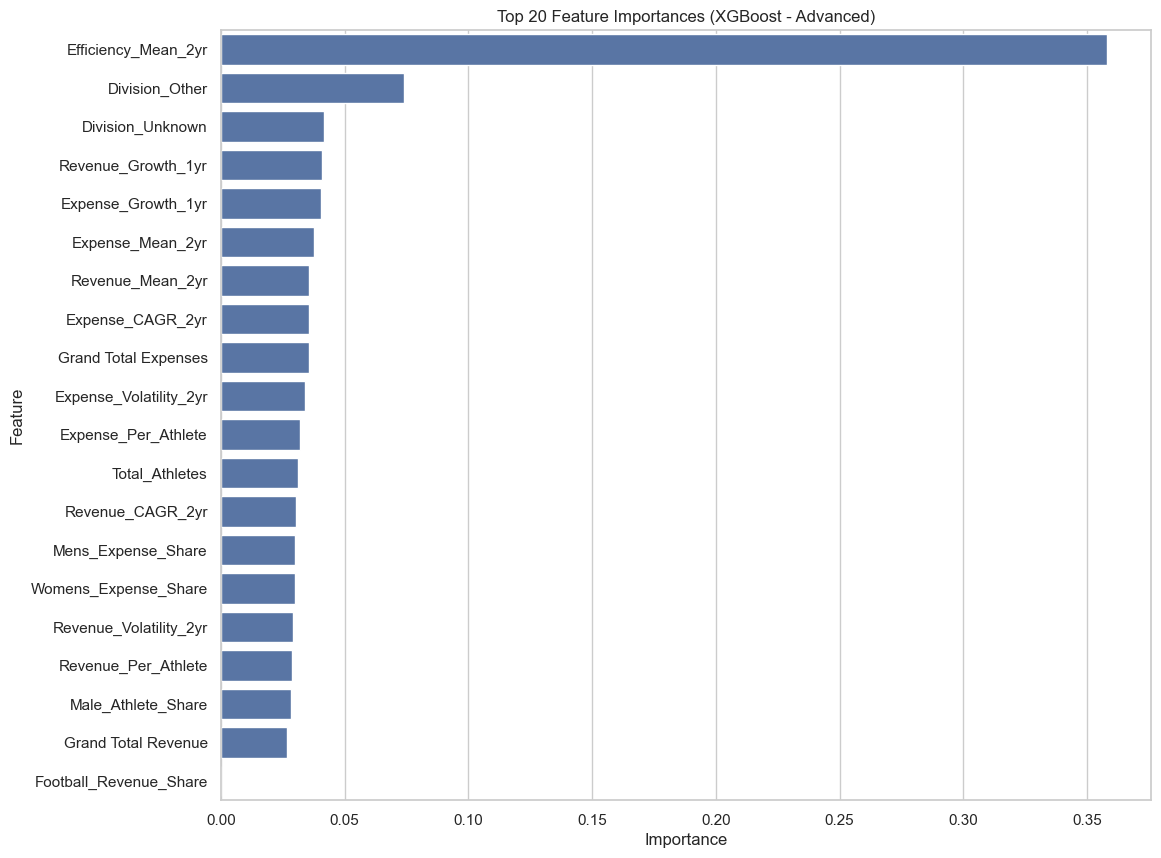

Top 20 Features:
                   Feature  Importance
9      Efficiency_Mean_2yr    0.357984
20          Division_Other    0.073887
21        Division_Unknown    0.041483
3       Revenue_Growth_1yr    0.040903
4       Expense_Growth_1yr    0.040512
8         Expense_Mean_2yr    0.037769
7         Revenue_Mean_2yr    0.035670
6         Expense_CAGR_2yr    0.035630
1     Grand Total Expenses    0.035611
11  Expense_Volatility_2yr    0.034002
19     Expense_Per_Athlete    0.031943
2           Total_Athletes    0.031311
5         Revenue_CAGR_2yr    0.030277
12      Mens_Expense_Share    0.030048
13    Womens_Expense_Share    0.029861
10  Revenue_Volatility_2yr    0.029115
18     Revenue_Per_Athlete    0.028839
17      Male_Athlete_Share    0.028370
0      Grand Total Revenue    0.026784
14  Football_Revenue_Share    0.000000


In [8]:
# Extract feature importance from XGBoost
xgb_model = pipeline_xgb.named_steps['classifier']
importances = xgb_model.feature_importances_
feature_names = X.columns

# Create a DataFrame
feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_imp_df = feature_imp_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(12, 10))
sns.barplot(x='Importance', y='Feature', data=feature_imp_df.head(20))
plt.title('Top 20 Feature Importances (XGBoost - Advanced)')
plt.show()

print("Top 20 Features:")
print(feature_imp_df.head(20))